https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification

In [99]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from torchvision import models
from torchvision.transforms import transforms
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import os
from PIL import Image

In [100]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [101]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')

In [102]:
print(train_df.shape)
print('='*15)
print(val_df.shape)
print('='*15)
print(train_df['category'].value_counts())
print('='*15)
print(val_df['category'].value_counts())

(1034, 2)
(133, 2)
category
2    348
1    345
0    341
Name: count, dtype: int64
category
2    45
0    44
1    44
Name: count, dtype: int64


In [103]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

In [104]:
class CustomImageDataset(Dataset):
    def __init__(self,dataframe,transform):
        self.dataframe= dataframe
        self.transform = transform
        self.labels = torch.tensor(dataframe['category']).to(device)
        
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self,indx):
        img_path = self.dataframe.iloc[indx,0]
        label = self.labels[indx]
        image = Image.open(img_path)
        
        if self.transform:
            image  = (self.transform(image)/255.0).to(device)

        return image,label            

In [105]:
train_dataset = CustomImageDataset(train_df,transform)
val_dataset = CustomImageDataset(val_df,transform) 

In [106]:
train_df

,image:FILE,category
0,train/healthy/healthy_train.98.jpg,0
1,train/healthy/healthy_train.148.jpg,0
2,train/healthy/healthy_train.306.jpg,0
3,train/healthy/healthy_train.305.jpg,0
4,train/healthy/healthy_train.40.jpg,0
...,...,...
1029,train/bean_rust/bean_rust_train.29.jpg,2
1030,train/bean_rust/bean_rust_train.311.jpg,2
1031,train/bean_rust/bean_rust_train.336.jpg,2
1032,train/bean_rust/bean_rust_train.329.jpg,2


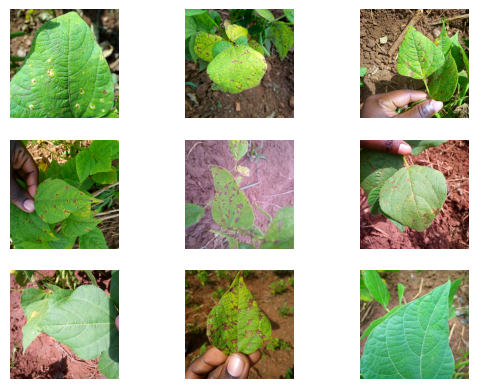

In [129]:
n_rows =3
n_columns = 3

f , axs = plt.subplots(n_rows,n_columns)
for row in range(n_rows):
    for col in range(n_columns):
        image= Image.open(train_df.sample(n=1)['image:FILE'].iloc[0]).convert('RGB')
        axs[row,col].imshow(image)
        axs[row,col].axis('off')
        
        


In [108]:
LR = 1e-3
BATCH_SIZE = 4
EPOCH = 15

In [109]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [110]:
googlenet_model = models.googlenet(weights='DEFAULT')

In [111]:
for param in googlenet_model.parameters():
    param.requires_grad = True
    


In [112]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [113]:
num_classes= len(train_df['category'].unique())
num_classes

3

In [114]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features,num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [115]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [116]:
loss = nn.CrossEntropyLoss()
optimazer= Adam(googlenet_model.parameters(),lr=LR)
total_loss_train_plot = []
total_acc_train_plot = []

In [117]:
for epoch in range(EPOCH):
    total_acc_train = 0
    total_loss_train = 0
    
    googlenet_model.train()
    for input,label in train_loader:
        optimazer.zero_grad()
        outputs = googlenet_model(input)
        train_loss = loss(outputs,label)
        total_loss_train += train_loss.item()
        
        train_loss.backward()
        
        train_acc = (torch.argmax(outputs,axis=1) == label).sum().item()
        total_acc_train += train_acc
        optimazer.step()
        
    total_loss_train_plot.append(round(total_loss_train/len(train_loader),4))
    total_acc_train_plot.append(round(total_acc_train/len(train_dataset)*100,4))
    
    print(f'Epoch:{epoch+1}/{EPOCH} Total train loss : {total_loss_train_plot[epoch]} Total train Acc:{total_acc_train_plot[epoch]}%')

Epoch:1/15 Total train loss : 0.82 Total train Acc:66.3443%
Epoch:2/15 Total train loss : 0.601 Total train Acc:78.1431%
Epoch:3/15 Total train loss : 0.5041 Total train Acc:81.6248%
Epoch:4/15 Total train loss : 0.4476 Total train Acc:82.5919%
Epoch:5/15 Total train loss : 0.4613 Total train Acc:81.6248%
Epoch:6/15 Total train loss : 0.3176 Total train Acc:88.3946%
Epoch:7/15 Total train loss : 0.3039 Total train Acc:89.1683%
Epoch:8/15 Total train loss : 0.2582 Total train Acc:89.8453%
Epoch:9/15 Total train loss : 0.2117 Total train Acc:92.3598%
Epoch:10/15 Total train loss : 0.2636 Total train Acc:90.4255%
Epoch:11/15 Total train loss : 0.2479 Total train Acc:90.619%
Epoch:12/15 Total train loss : 0.2093 Total train Acc:92.0696%
Epoch:13/15 Total train loss : 0.1976 Total train Acc:92.7466%
Epoch:14/15 Total train loss : 0.1945 Total train Acc:93.617%
Epoch:15/15 Total train loss : 0.1613 Total train Acc:94.0039%


In [154]:
with torch.no_grad():
    total_acc_test =0
    
    googlenet_model.eval()
    for input,label in val_loader:
        
        prediction = googlenet_model(input)
        acc = (torch.argmax(prediction,axis=1)==label).sum().item()
        total_acc_test += acc

    print(round(total_acc_test/len(val_dataset)*100,4))
        

97.7444


In [159]:
googlenet_model = models.googlenet(weights='DEFAULT')
for param in googlenet_model.parameters():
    param.requires_grad= False
    
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features,num_classes)
googlenet_model.fc.requires_grad = True

In [160]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [161]:
for epoch in range(EPOCH):
    total_acc_train = 0
    total_loss_train = 0
    
    googlenet_model.train()
    for input,label in train_loader:
        optimazer.zero_grad()
        outputs = googlenet_model(input)
        train_loss = loss(outputs,label)
        total_loss_train += train_loss.item()
        
        train_loss.backward()
        
        train_acc = (torch.argmax(outputs,axis=1) == label).sum().item()
        total_acc_train += train_acc
        optimazer.step()
        
    total_loss_train_plot.append(round(total_loss_train/len(train_loader),4))
    total_acc_train_plot.append(round(total_acc_train/len(train_dataset)*100,4))
    
    print(f'Epoch:{epoch+1}/{EPOCH} Total train loss : {total_loss_train_plot[epoch]} Total train Acc:{total_acc_train_plot[epoch]}%')

Epoch:1/15 Total train loss : 0.82 Total train Acc:66.3443%
Epoch:2/15 Total train loss : 0.601 Total train Acc:78.1431%
Epoch:3/15 Total train loss : 0.5041 Total train Acc:81.6248%
Epoch:4/15 Total train loss : 0.4476 Total train Acc:82.5919%
Epoch:5/15 Total train loss : 0.4613 Total train Acc:81.6248%
Epoch:6/15 Total train loss : 0.3176 Total train Acc:88.3946%
Epoch:7/15 Total train loss : 0.3039 Total train Acc:89.1683%
Epoch:8/15 Total train loss : 0.2582 Total train Acc:89.8453%
Epoch:9/15 Total train loss : 0.2117 Total train Acc:92.3598%
Epoch:10/15 Total train loss : 0.2636 Total train Acc:90.4255%
Epoch:11/15 Total train loss : 0.2479 Total train Acc:90.619%
Epoch:12/15 Total train loss : 0.2093 Total train Acc:92.0696%
Epoch:13/15 Total train loss : 0.1976 Total train Acc:92.7466%
Epoch:14/15 Total train loss : 0.1945 Total train Acc:93.617%
Epoch:15/15 Total train loss : 0.1613 Total train Acc:94.0039%


In [162]:
with torch.no_grad():
    total_acc_test =0
    
    googlenet_model.eval()
    for input,label in val_loader:
        
        prediction = googlenet_model(input)
        acc = (torch.argmax(prediction,axis=1)==label).sum().item()
        total_acc_test += acc

    print(round(total_acc_test/len(val_dataset)*100,4))
        

33.0827
